# EMToolKit Dashboard Example
## Simple/Sparse Method

### Import Statements

In [ ]:
# Standard library imports
import importlib
from sys import path

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from sunpy.map import Map
from sunpy.net import Fido, attrs as a, vso
from sunpy.time import TimeRange


# EMToolKit specific imports
import EMToolKit
import EMToolKit.visualization
import EMToolKit.EMToolKit as emtk



# Jupyter/IPython specific commands
%matplotlib widget
# matplotlib.use("qt5Agg")
# jupyter nbextension enable --py widgetsnbextension

# Configuration settings
# plt.rcParams.update({'font.size': 18, 'figure.figsize': [20, 15], 'image.origin': 'lower'})
plt.rcParams.update({'image.origin': 'lower'})
np.set_printoptions(linewidth=128)

# Setting the base path
base_path = "../"
emtk_path = base_path + 'code/'
path.append(emtk_path)

# Display HTML for notebook width
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

# Initialization
em_collection = 0

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)



In [ ]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False
recalc_sparse = False
recalc_simple = False

### Download the Imagery

In [ ]:
from EMToolKit.instruments.aia import download_sdo_data

# date='2012/07/11 18:54:00'
date='2010/07/25 17:58:44'


# Download the data
paths, sdo_data_dir = download_sdo_data(base_path, date, redownload=redownload)


### Load and Crop the Imagery

In [ ]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper

# xlen = 400*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
# ylen = 400*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
# xl = -0*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
# yl = -0*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA data:
maps = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(maps, temp_step_size=0.025)

In [ ]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

In [ ]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

do_plot = False

if do_plot:
    fig, axs = plt.subplots(2, 3)
    axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,0].set(title='AIA 193 Angstrom')
    axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
    axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

    axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,1].set(title='AIA 335 Angstrom')
    axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
    axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

    axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,2].set(title='AIA 94 Angstrom')
    axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
    axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

### Compute the Differential Emission Measures

In [ ]:
from EMToolKit.algorithms.sparse_em_wrapper import autoloading_sparse_em_wrapper

# Compute the DEM for Cheung et al. sparse EM method:
# Make DEM sequence from the DEM and add it to the collection:
sparse_em_demsequence, (spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm) = \
                            autoloading_sparse_em_wrapper(datasequence, sdo_data_dir, recalc_sparse)

em_collection.add_model(sparse_em_demsequence)
spars_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=spars_algorithm)

In [ ]:
from EMToolKit.algorithms.simple_reg_dem_wrapper import autoloading_simple_reg_dem_wrapper

# Compute the DEM for Plowman & Caspi simple_reg_dem method:
# Make DEM sequence from the DEM and add it to the collection:
simple_reg_demsequence, (simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm) = \
                            autoloading_simple_reg_dem_wrapper(datasequence, sdo_data_dir, recalc_simple)

em_collection.add_model(simple_reg_demsequence)
simpl_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=simpl_algorithm)

In [ ]:
from EMToolKit.util import calc_resids, plot_resids
spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2, '\nspars_em Chi squared = ',spars_chi2)

do_resid_plots = True
if do_resid_plots:
    # Plot Residuals:
        plot_resids(em_collection, simpl_resids,simpl_algorithm)
        plot_resids(em_collection, spars_resids,spars_algorithm)


### Run the Dashboard

Output()

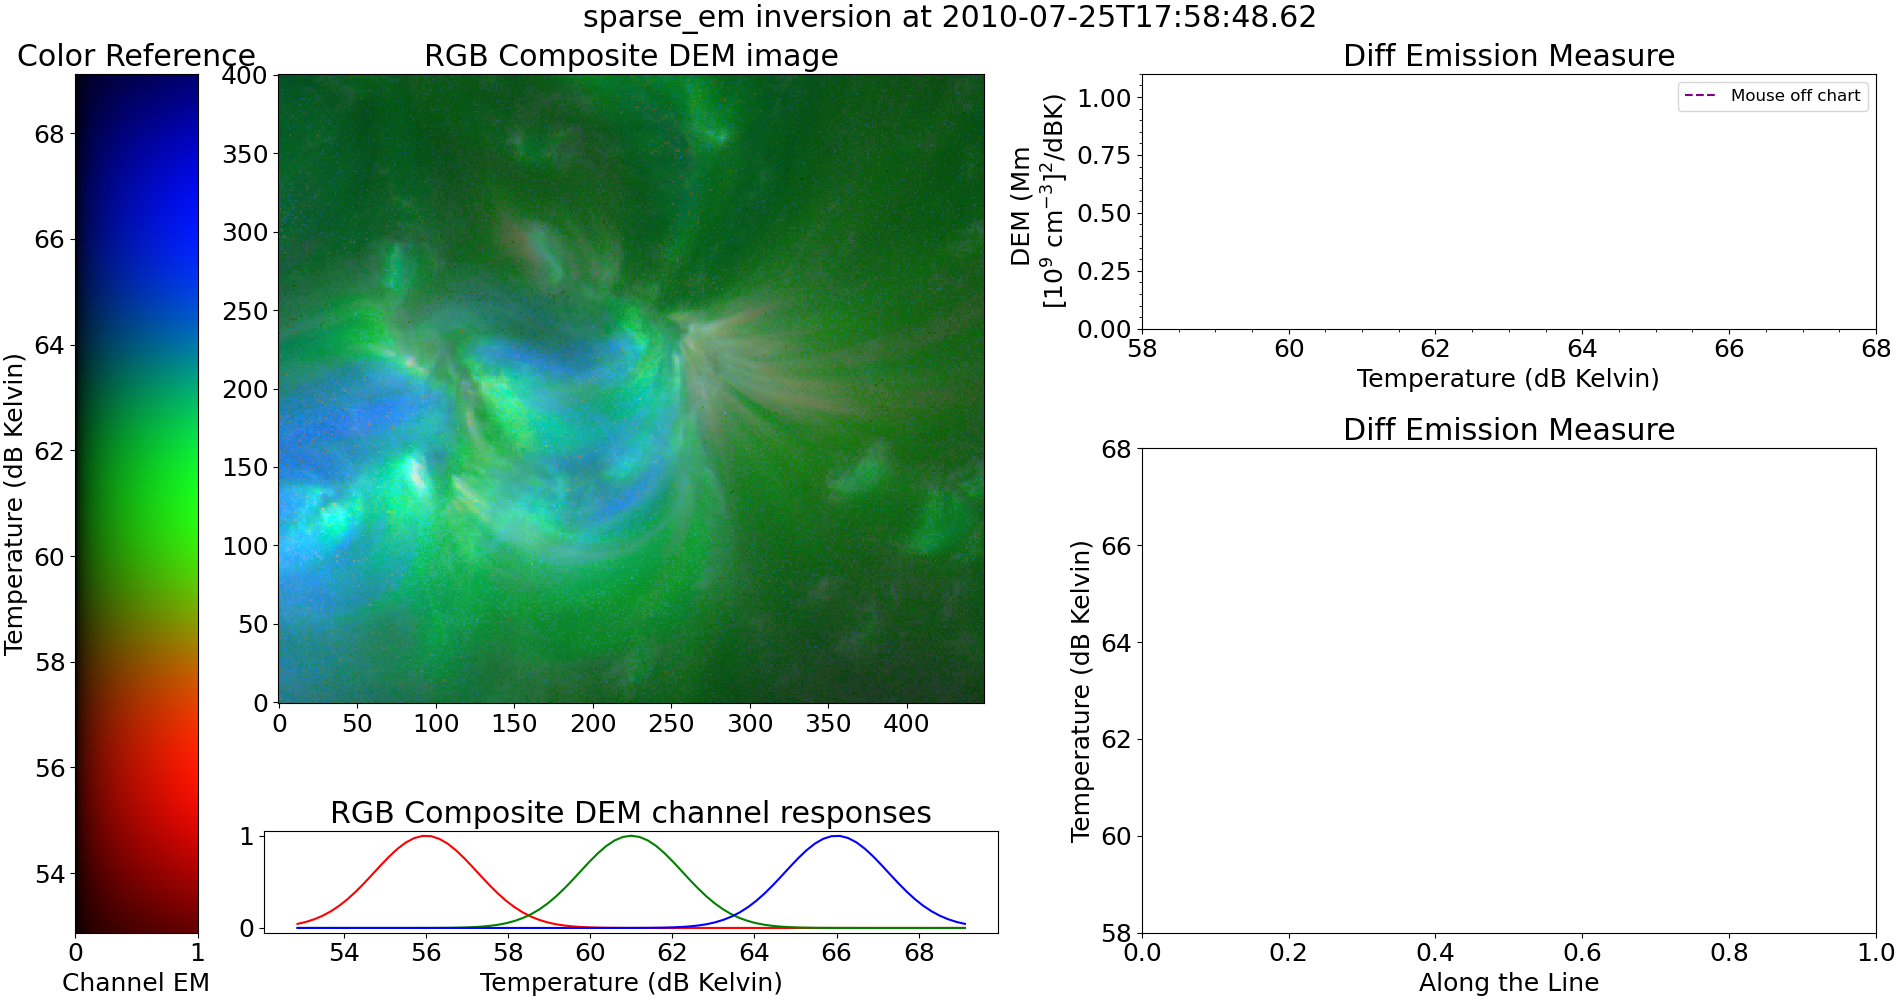

In [19]:
# Get the most recent version from the tool kit:
import EMToolKit.visualization.dashboard
importlib.reload(EMToolKit.visualization.dashboard)
importlib.reload(EMToolKit)
from EMToolKit.visualization.dashboard import dashboard_object

# Create the dashboard:
dash = dashboard_object(em_collection)
dash.display()

